In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
folder_O = '/content/drive/My Drive/ColabData/combined'
image_size = (500, 500)
batch_size = 32

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=5,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = datagen.flow_from_directory(
    folder_O + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True  
)

test_gen = test_datagen.flow_from_directory(
    folder_O + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False 
)

Found 54 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [ ]:

from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

model = VGG16(weights='imagenet')
model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500,500,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
epochs = 10

history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )


Epoch 1/10
2/2 [==============================] - 127s 63s/step - loss: 5.9616 - categorical_accuracy: 0.5185 - val_loss: 20.4522 - val_categorical_accuracy: 0.4792
Epoch 2/10
2/2 [==============================] - 7s 4s/step - loss: 15.9565 - categorical_accuracy: 0.5185 - val_loss: 3.1566 - val_categorical_accuracy: 0.5208
Epoch 3/10
2/2 [==============================] - 7s 4s/step - loss: 2.3832 - categorical_accuracy: 0.5556 - val_loss: 0.3864 - val_categorical_accuracy: 0.8125
Epoch 4/10
2/2 [==============================] - 7s 5s/step - loss: 1.3003 - categorical_accuracy: 0.6481 - val_loss: 0.0024 - val_categorical_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 7s 5s/step - loss: 0.2343 - categorical_accuracy: 0.9259 - val_loss: 2.0241 - val_categorical_accuracy: 0.6250
Epoch 6/10
2/2 [==============================] - 7s 5s/step - loss: 0.5209 - categorical_accuracy: 0.8148 - val_loss: 0.0057 - val_categorical_accuracy: 1.0000
Epoch 7/10
2/2 [=============

In [ ]:
model.save('/content/drive/My Drive/ColabData/tictactoe')

INFO:tensorflow:Assets written to: /content/drive/My Drive/ColabData/tictactoe/assets


In [ ]:
model.save("/content/drive/My Drive/ColabData")

In [ ]:
tf.saved_model.save(model, '/content/drive/My Drive/ColabData')

INFO:tensorflow:Assets written to: /content/drive/My Drive/ColabData/assets


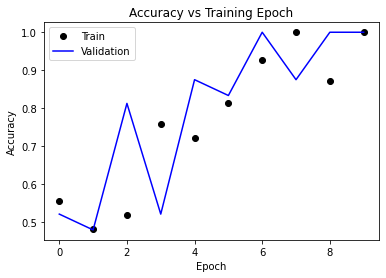

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.06


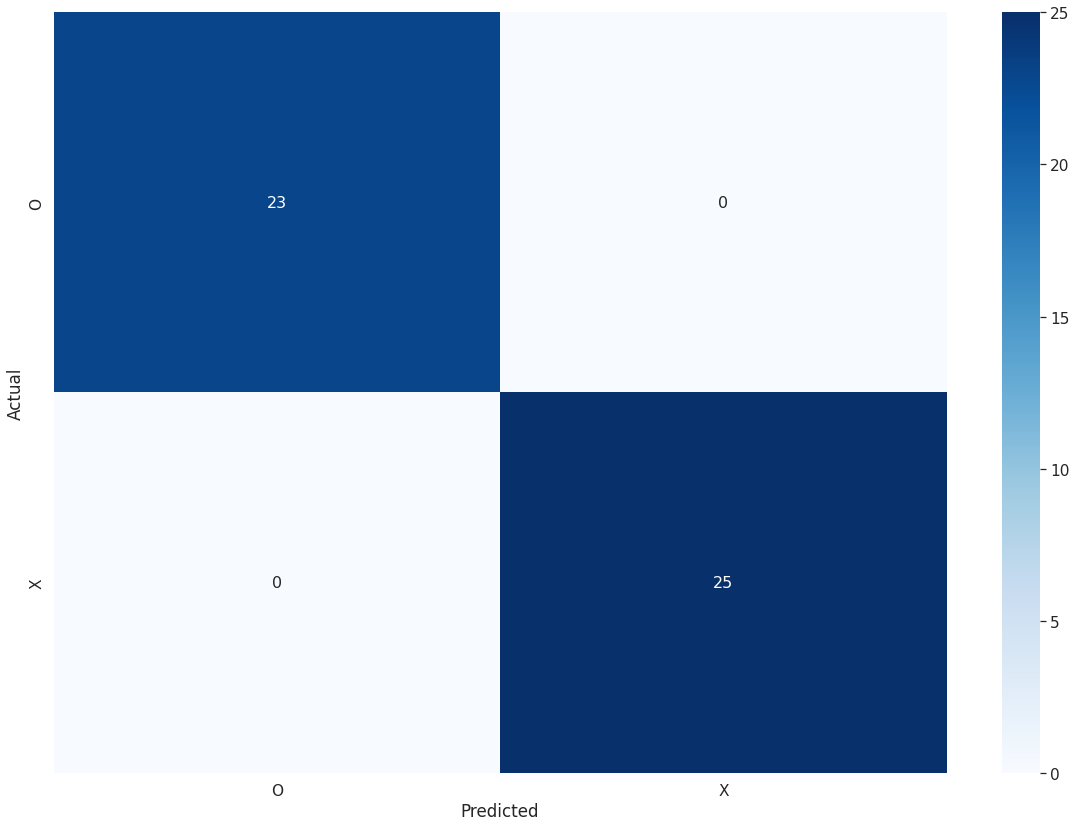

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['O', 'X']

test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size